In [12]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# 로그 레벨 : ERROR
tf.logging.set_verbosity(tf.logging.ERROR)
# 10줄만 보여주기
pd.options.display.max_rows = 10
# 소수점 이하 한 자리 수까지만
pd.options.display.float_format = '{:.1f}'.format

# 타이타닉 training 데이터 불러오기
# titanic_train_dataframe = pd.read_csv("./data/train.csv", sep=",", low_memory=False, na_values=[], skiprows=1)
titanic_train_dataframe = pd.read_csv("./data/train.csv", sep=",", na_values=[])
# 데이터를 랜덤하게 섞기
titanic_train_dataframe = titanic_train_dataframe.reindex(
    np.random.permutation(titanic_train_dataframe.index)
)
## NaN 처리 시도
titanic_train_dataframe[titanic_train_dataframe.isnull().any(axis=1)]
titanic_train_dataframe.fillna('', inplace=True)
# titanic_train_dataframe.dtypes

In [13]:
def preprocess_features(titanic_dataframe):
    # 타이타닉 데이터 프레임의 features를 준비
    # param {DataFrame} titanic_dataframe : 로드된 타이타닉 데이터 프레임
    # return 준비된 features 데이터 프레임
    
    # 데이터 의미
    # Pclass : 티켓 클래스
    # Sex : 성별
    # Age : 나이 (모를 수 있음 - 빈칸, 소수점)
    # SibSp: 형제 자매 또는 배우자 수
    # Parch : 부모님 또는 자식의 수
    # Ticket : 티켓 번호
    # Fare : 티켓 가격
    # Carbin : 선실 번호
    # Embarked : 승선 항, C = Cherbourg, Q = Queenstown, S = Southampton
    # 타이타닉 데이터 프레임 중에서 필요한 features 선택
    selected_features = titanic_dataframe[
        ["Pclass",
         "Sex",
         "Age",
         "SibSp",
         "Parch",
         "Fare",
         "Embarked"
        ]
    ]
    processed_features = selected_features.copy()
    # 만약 추가로 합성할 데이터가 있으면 이 아래에 작성
    
    # float 형식이 아닌 값들을 float 또는 integer 형식으로 변환
    # 남성이면 1, 여성이면 0
    processed_features["SexNum"] = np.where(titanic_dataframe["Sex"] == 'male', 1, 0)
    # Embarked 값에 따라 새로운 Column 생성
    processed_features["ES"] = np.where(processed_features["Embarked"] == "S", 1, 0)
    processed_features["EC"] = np.where(processed_features["Embarked"] == "C", 1, 0)
    processed_features["EQ"] = np.where(processed_features["Embarked"] == "Q", 1, 0)
    # 
    
    return processed_features

def preprocess_targets(titanic_dataframe):
    # 타이타닉 데이터 프레임의 targets 준비
    # param {DataFrame} titanic_dataframe : 로드된 타이타닉 데이터 프레임
    # return 준비된 targets 데이터 프레임
    
    # 생존 여부가 target
    output_targets = pd.DataFrame()
    output_targets["Survived"] = titanic_dataframe["Survived"]
    
    return output_targets

In [14]:
training_examples = preprocess_features(titanic_train_dataframe.head(500))
training_targets = preprocess_targets(titanic_train_dataframe.head(500))

validation_examples = preprocess_features(titanic_train_dataframe.tail(300))
validation_targets = preprocess_targets(titanic_train_dataframe.tail(300))

print("Tranining examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
print("Tranining targets summary:")
display.display(training_targets.describe())
print("Validation examples summary:")
display.display(validation_targets.describe())

Tranining examples summary:


,Pclass,SibSp,Parch,Fare,SexNum,ES,EC,EQ
count,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
mean,2.3,0.5,0.4,34.8,0.6,0.7,0.2,0.1
std,0.8,1.1,0.8,56.1,0.5,0.5,0.4,0.3
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,0.0,0.0,7.9,0.0,0.0,0.0,0.0
50%,3.0,0.0,0.0,15.4,1.0,1.0,0.0,0.0
75%,3.0,1.0,0.0,34.4,1.0,1.0,0.0,0.0
max,3.0,8.0,6.0,512.3,1.0,1.0,1.0,1.0


Validation examples summary:


,Pclass,SibSp,Parch,Fare,SexNum,ES,EC,EQ
count,300.0,300.0,300.0,300.0,300.0,300.0,300.0,300.0
mean,2.4,0.5,0.4,28.9,0.7,0.7,0.2,0.1
std,0.8,1.1,0.8,38.3,0.5,0.4,0.4,0.3
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.0,0.0,0.0,7.9,0.0,0.0,0.0,0.0
50%,3.0,0.0,0.0,14.5,1.0,1.0,0.0,0.0
75%,3.0,1.0,1.0,28.8,1.0,1.0,0.0,0.0
max,3.0,8.0,5.0,247.5,1.0,1.0,1.0,1.0


Tranining targets summary:


,Survived
count,500.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation examples summary:


,Survived
count,300.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


In [4]:
# 피어슨 상관계수를 통해 상관행렬을 만들고, 상관 관계를 찾기
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["Survived"]

correlation_dataframe.corr()

,Pclass,SibSp,Parch,Fare,SexNum,ES,EC,EQ,target
Pclass,1.0,0.1,-0.0,-0.5,0.2,0.1,-0.2,0.2,-0.4
SibSp,0.1,1.0,0.4,0.2,-0.1,0.1,-0.1,-0.0,-0.0
Parch,-0.0,0.4,1.0,0.2,-0.3,0.1,-0.0,-0.1,0.1
Fare,-0.5,0.2,0.2,1.0,-0.2,-0.2,0.3,-0.1,0.3
SexNum,0.2,-0.1,-0.3,-0.2,1.0,0.1,-0.0,-0.1,-0.5
ES,0.1,0.1,0.1,-0.2,0.1,1.0,-0.8,-0.5,-0.1
EC,-0.2,-0.1,-0.0,0.3,-0.0,-0.8,1.0,-0.2,0.2
EQ,0.2,-0.0,-0.1,-0.1,-0.1,-0.5,-0.2,1.0,-0.0
target,-0.4,-0.0,0.1,0.3,-0.5,-0.1,0.2,-0.0,1.0


In [5]:
def construct_feature_columns(input_features):
#   Args:
#     input_features: The names of the numerical input features to use.
#   Returns:
#     A set of feature columns

  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [6]:

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
#     """Trains a linear regression model of one feature.
  
#     Args:
#       features: pandas DataFrame of features
#       targets: pandas DataFrame of targets
#       batch_size: Size of batches to be passed to the model
#       shuffle: True or False. Whether to shuffle the data.
#       num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
#     Returns:
#       Tuple of (features, labels) for next data batch
#     """
    
    # Convert pandas data into a dict of np arrays
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(300)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
def train_model (
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets
) :
    periods = 10
    steps_per_period = steps / periods
    
    # 선형 회귀 학습 모델 사용
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
#     # FTRL 최적화 모델 사용
#     optimizer = tf.train.FtrlOptimizer(learning_rate = learning_rate)
#     optimizer = tf.contrib.estimator.clip_gradients_by_norm(ftrlOptimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer=optimizer
    )
    
    # Training 입력값 함수
    training_input_fn = lambda: my_input_fn(
        training_examples, training_targets["Survived"], batch_size=batch_size 
    )
    # 예측 테스트 입력값 함수
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, training_targets["Survived"], num_epochs=1, shuffle=False
    )
    # 검증 입력값
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples, validation_targets["Survived"], num_epochs=1, shuffle=False
    )
    
    print("Traning model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    
    for period in range(0, periods):
        # 선형 회귀 학습 모델로 Training
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # 학습한 데이터를 이용해서 예측 결과 확인
        # 예측 테스트 입력값을 통해 결과 확인
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        # 검증 입력값을 통해 경과 확인
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Training 결과와 검증 결과에서 손실값을 계산
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets)
        )
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets)
        )
        # 손실값 출력
        print("    period %02d : %0.2f" % (period, training_root_mean_squared_error))
        #
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    
    # 결과를 시각화하여 보여주기
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor

In [ ]:
def get_quantile_based_boundaries(feature_values, num_buckets):
    # 버킷화
    # {TensorFlow feature column} feature_values : 텐서플로우 feature 컬럼
    # {intger} num_buckets = 나눌 버킷의 수
    boundaries = np.arange(1.0, num_buckets) / num_buckets
    quantiles = feature_values.quantile(boundaries)
    return [quantiles[q] for q in quantiles.keys()]

In [ ]:
# def construct_feature_columns(titanic_dataframe):
#     # TensorFlow feature 컬럼 모음
#     pclass = tf.feature_columns.numeric_columns("Pclass")
#     sexNum = tf.feature_columns.numeric_columns("SexNum")
#     sibsp = tf.feature_columns.numeric_columns("SibSp")
#     parch = tf.feature_columns.numeric_columns("Parch")
#     fare = tf.feature_columns.numeric_columns("Fare")
    
#     # 컬럼 버킷화
#     bk_pclass = tf.feature_columns.bucketized_column(
#         pclass, boudaries=get_quantile_based_boundaries(titanic_dataframe['Pclass'], 3)
#     )
#     bk_fare = tf.feature_columns.bucketized_column(
#         fare, boudaries=get_quantile_based_boundaries(titanic_dataframe["Fare"], 7)
#     )
#     # .... 더 작성
    
#     feature_columns = set([
#         bk_pclass, bk_fare
#     ])
    
#     return feature_columns

Traning model...
RMSE (on training data):
    period 00 : 0.55
    period 01 : 0.54
    period 02 : 0.54
    period 03 : 0.54
    period 04 : 0.58
    period 05 : 0.55
    period 06 : 0.55
    period 07 : 0.58
    period 08 : 0.61
    period 09 : 0.64
Model training finished.


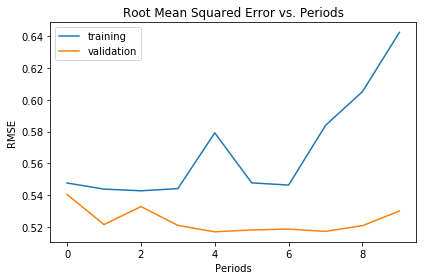

In [10]:
# 최소한의 feature만을 사용하려면 여기서 세팅
minimal_features = [
    "Pclass",
#     "Sex",
#     "Age",
#     "SibSp",
#     "Parch",
    "Fare",
#     "Embarked"
    "SexNum"
#     "EC",
#     "ES",
#     "EQ"
]

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

train_model(
    learning_rate=0.0001,
    steps=100,
    batch_size=1,
    construct_feature_columns(training_examples),
#     training_examples=training_examples,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
#     validation_examples=validation_examples,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets
)